In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from causalml.inference.meta import LRSRegressor

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseDRRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'


In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "C:\\Users\\91952\\AppData\\Roaming\\gcloud\\application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

In [5]:
testQuery = """
SELECT BlockGroupCode,
       deploymentRate21 - deploymentRate15 AS deploymentRateDiff,
       pop / NULLIF(landArea, 0) AS popDensity,
       houseRoadDensity,
       unemploymentRate,
       houseOwnerRate,
       maleRate,
       ageUnder17Rate,
       ageBetween18and24Rate,
       ageAbove65Rate,
       income AS medianIncome,
       aboveHighSchoolRate,
       aboveBachelorRate,
       whiteRate,
       MovedIn1yearRate,
       newlyMovedRate,
       demRatio,
       IFNULL(HadFund, 0) AS hadFund,
       avgAnnualTemp
FROM `broadband-data.capstone.blockgroup_2020_normal`
LEFT JOIN `broadband-data.usac_high_cost.Block_Group_Code_2015_2021` ON BlockGroupCode = Census_Block_Group_Code
WHERE SUBSTR(BlockGroupCode, 1, 2) != "02" and SUBSTR(BlockGroupCode, 1, 2) != "15"
"""

# Runs the query and converts it into a dataframe
df = client.query(testQuery).to_dataframe()

In [6]:
import causalml
print(causalml.__version__)

0.13.0


In [7]:
df = df.dropna()
df = df.astype({'medianIncome': 'int32'})
df = df.astype({'hadFund': 'int32'})
for column in df:
    #if column == 'popDensity':
    #    df[column] = df[column].clip(upper=60000)
    #if column == 'houseRoadDensity':
    #    df[column] = df[column].clip(upper=1)
    if column != 'BlockGroupCode' and column != 'deploymentRateDiff' and column != 'hadFund':
        df[column] = (df[column] - df[column].mean()) / df[column].std()
        #df[column] = df[column] / (df[column].max() - df[column].min())
df.describe()

,deploymentRateDiff,popDensity,houseRoadDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,demRatio,hadFund,avgAnnualTemp
count,201559.000000,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,2.015590e+05,201559.000000,2.015590e+05
mean,0.084352,-6.472330e-17,8.971722e-18,1.367791e-16,-1.072799e-15,-5.761643e-16,4.044149e-16,-2.256150e-17,-1.128075e-17,-2.707380e-17,2.899153e-16,-2.876591e-16,-1.568024e-16,4.061070e-17,-1.725955e-16,-3.040162e-16,0.191180,-9.701445e-17
std,0.222527,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.393231,1.000000e+00
min,-0.980392,-4.158997e-01,-6.066838e-02,-9.545499e-01,-2.526108e+00,-7.466161e+00,-2.510086e+00,-1.110991e+00,-1.658689e+00,-1.769287e+00,-7.078468e+00,-1.473301e+00,-2.804569e+00,-1.299735e+00,-7.906905e-01,-2.450976e+00,0.000000,-3.229406e+00
25%,0.000000,-3.849308e-01,-4.792107e-02,-6.616525e-01,-6.410703e-01,-5.701467e-01,-6.313289e-01,-5.212822e-01,-6.643113e-01,-6.784824e-01,-4.129709e-01,-7.751128e-01,-4.947519e-01,-7.080791e-01,-6.712394e-01,-7.676642e-01,0.000000,-7.810800e-01
50%,0.000000,-2.402631e-01,-2.907371e-02,-2.545004e-01,2.361601e-01,1.029493e-02,5.365217e-03,-1.712737e-01,-1.510577e-01,-2.281031e-01,2.941243e-01,-2.482091e-01,3.520915e-01,-2.303183e-01,-3.227523e-01,-2.536041e-02,0.000000,-2.099294e-01
75%,0.021624,-9.025373e-03,-5.467497e-03,3.522717e-01,8.085686e-01,5.628643e-01,6.286256e-01,2.609501e-01,4.471267e-01,4.238955e-01,7.195502e-01,6.007946e-01,7.845937e-01,4.564189e-01,2.949834e-01,7.603386e-01,0.000000,7.972678e-01
max,1.000000,4.140163e+01,4.280393e+02,1.587078e+01,1.332157e+00,8.334619e+00,6.498734e+00,1.144734e+01,8.102258e+00,4.785392e+00,1.067168e+00,3.336690e+00,1.016012e+00,8.218431e+00,1.448295e+01,2.136759e+00,1.000000,2.531886e+00


In [8]:
df.head()

,BlockGroupCode,deploymentRateDiff,popDensity,houseRoadDensity,unemploymentRate,houseOwnerRate,maleRate,ageUnder17Rate,ageBetween18and24Rate,ageAbove65Rate,medianIncome,aboveHighSchoolRate,aboveBachelorRate,whiteRate,MovedIn1yearRate,newlyMovedRate,demRatio,hadFund,avgAnnualTemp
0,240037401023,0.010740,-0.381204,-0.043344,-0.954550,-0.549004,0.472863,-0.995695,0.947843,0.057712,0.474453,-0.371914,1.382442,0.378117,-0.386802,-0.227658,0.826177,0,-0.134693
1,060530106061,0.265783,-0.414360,-0.059617,-0.531730,-0.728507,1.205153,-0.227818,0.928689,-0.018003,0.513728,-2.005627,-0.686159,-1.071843,-0.179729,-0.339857,0.408568,1,0.078111
2,310539644001,0.111845,-0.395262,-0.052943,0.573817,0.215893,0.478272,1.279060,-0.109671,-0.448801,-0.419950,-0.934952,-0.729214,0.768085,0.074204,0.494734,-1.027645,1,-0.740131
3,040130405181,0.903442,-0.415024,-0.058759,0.363468,0.743968,-1.869074,-0.823490,-0.968512,1.321632,-0.653932,0.554680,-0.585633,0.824674,-0.434915,0.106058,-1.282481,1,1.406518
4,010770115023,0.053843,-0.408319,-0.056869,-0.554627,1.216782,0.203530,0.264943,-0.146938,0.178464,0.471460,0.990349,0.406182,0.878242,-0.535878,-0.409581,-1.628974,1,0.442047


In [9]:
xCol = ['popDensity', 'houseRoadDensity', 'unemploymentRate', 'houseOwnerRate', 'maleRate', 'ageUnder17Rate',
        'ageBetween18and24Rate', 'ageAbove65Rate', 'medianIncome', 'aboveHighSchoolRate', 'aboveBachelorRate', 'whiteRate',
        'MovedIn1yearRate', 'newlyMovedRate', 'demRatio', 'avgAnnualTemp']
X = df[xCol]

In [10]:
y = df['deploymentRateDiff']

In [11]:
treatment = df['hadFund']

In [12]:
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X, treatment)

### S-learner

In [14]:
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.24089363]), array([0.23715661]), array([0.24463064]))
ATE estimate: 0.241
ATE lower bound: 0.237
ATE upper bound: 0.245


In [15]:
learner_s = BaseSRegressor(learner=RandomForestRegressor(max_depth=10, random_state=0))
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print('ATE estimate: {:.03f}'.format(ate_s[0]))

ATE estimate: 0.079


### T-learner

In [16]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.0711794]), array([0.0685834]), array([0.07377541]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.0711794]), array([0.0685834]), array([0.07377541]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-0.03924978]), array([-0.07187085]), array([-0.00662871]))


In [17]:
# Calling the Base Learner class and feeding in Random Forest
learner_t = BaseTRegressor(learner=RandomForestRegressor(max_depth=10, random_state=0))
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseTRegressor class and using Random Forest (different result):')
print(ate_t)

Using the BaseTRegressor class and using Random Forest (different result):
(array([0.07978217]), array([0.07693742]), array([0.08262692]))


In [18]:
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Neural Network (MLP)): 0.11 (0.11, 0.11)


### X-learner

In [19]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.07099937]), array([0.06841857]), array([0.07358018]))

Using the BaseXRegressor class and using Linear Regression:
(array([-0.03924978]), array([-0.07187085]), array([-0.00662871]))


In [20]:
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y, ps)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using XGBoost): 0.07 (0.07, 0.07)


### R-learner

In [21]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.05348516]), array([0.05347802]), array([0.05349231]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.16434657]), array([0.16432455]), array([0.16436859]))


In [22]:
# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=ps, sample_weight=sample_weight)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.05899026]), array([0.05898311]), array([0.05899741]))


In [23]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.06356595]), array([0.06355878]), array([0.06357311]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.12056023]), array([0.12055105]), array([0.12056941]))


### DR-learner

In [24]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseDRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseDRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=ps)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.06534541]), array([0.06261817]), array([0.06807265]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.12869893]), array([0.09570057]), array([0.1616973]))


### Conditional Average Treatment Effect

In [13]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=ps)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=ps)

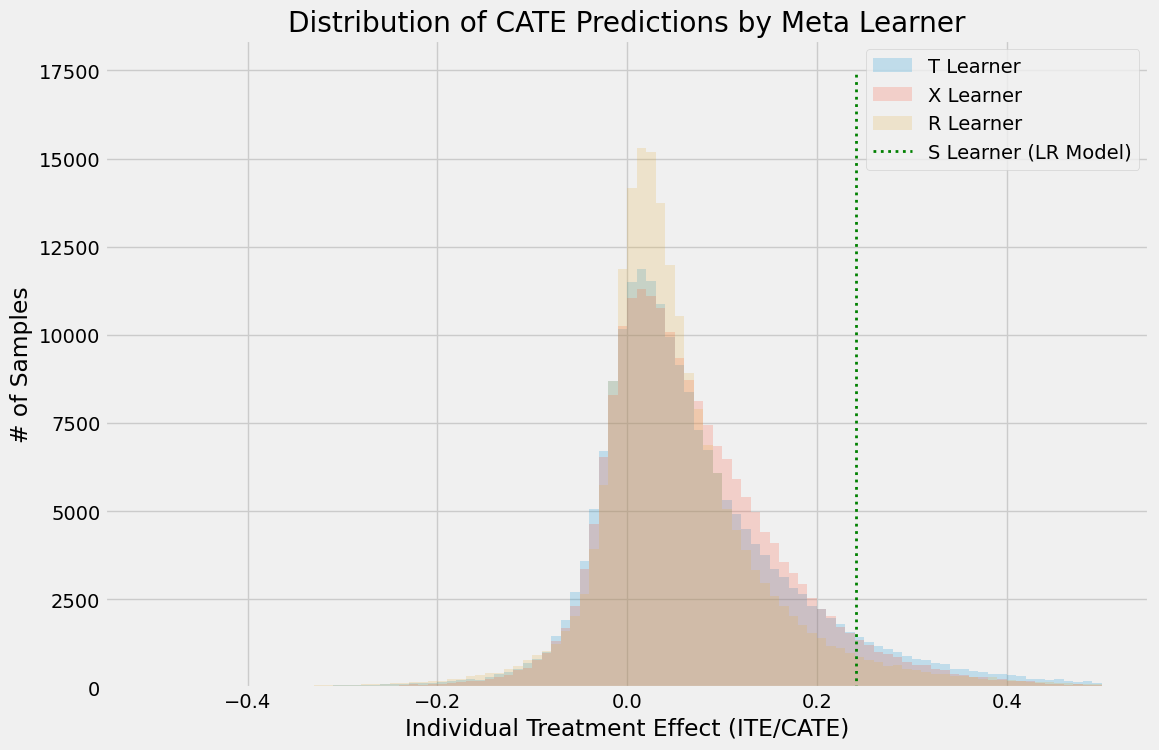

In [16]:
alpha=0.2
bins=100
ranges=(-0.5, 0.5)
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, range=ranges, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, range=ranges, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, range=ranges, label='R Learner')
plt.vlines(cate_s[0], 0, 17500, label='S Learner (LR Model)', linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
plt.legend()
plt.show()

### Feature Importance

In [27]:
base_algo = XGBRegressor()

In [28]:
slearner = BaseSRegressor(base_algo)
slearner.estimate_ate(X, treatment, y)

array([0.07257543])

In [29]:
slearner_tau = slearner.fit_predict(X, treatment, y)

In [30]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=xCol)

{1: aboveBachelorRate        0.314403
 houseRoadDensity         0.142413
 avgAnnualTemp            0.119789
 popDensity               0.114150
 aboveHighSchoolRate      0.096633
 demRatio                 0.064754
 medianIncome             0.039172
 MovedIn1yearRate         0.024343
 whiteRate                0.017985
 unemploymentRate         0.014153
 ageUnder17Rate           0.013330
 maleRate                 0.012074
 newlyMovedRate           0.010319
 houseOwnerRate           0.007236
 ageAbove65Rate           0.005328
 ageBetween18and24Rate    0.003918
 dtype: float64}

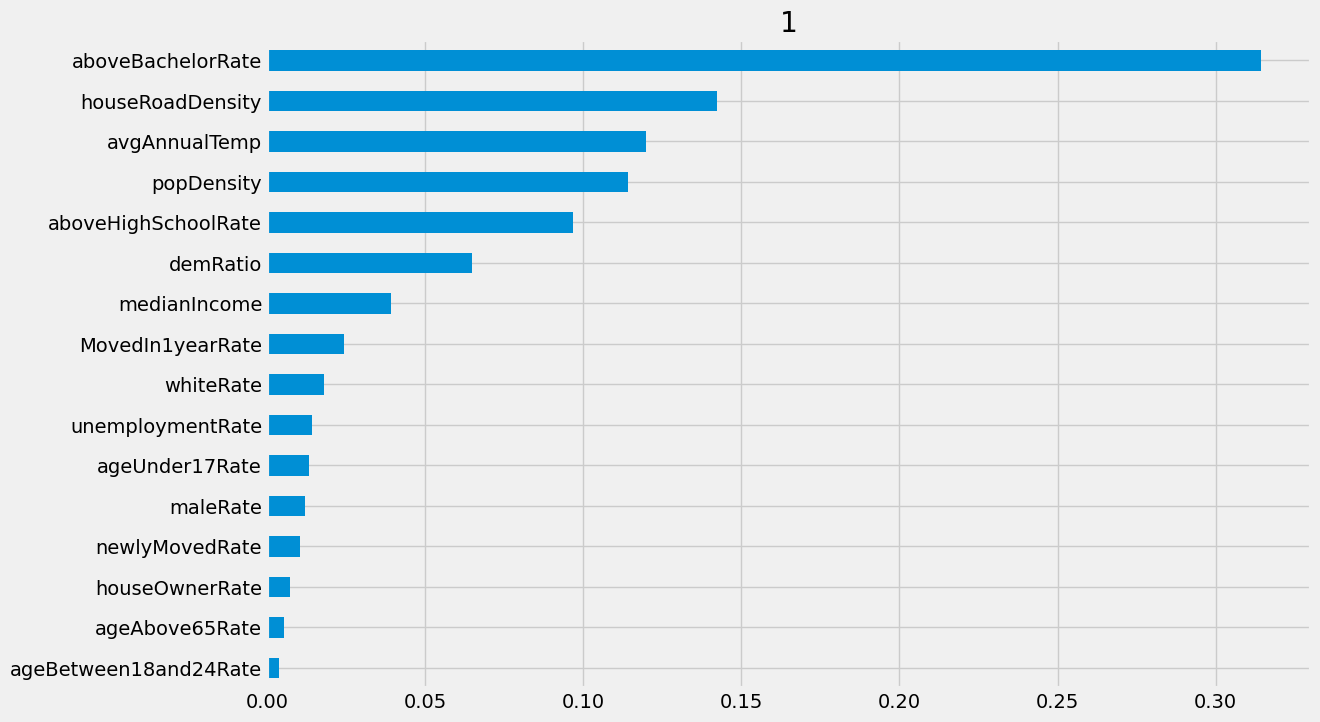

In [31]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=xCol)

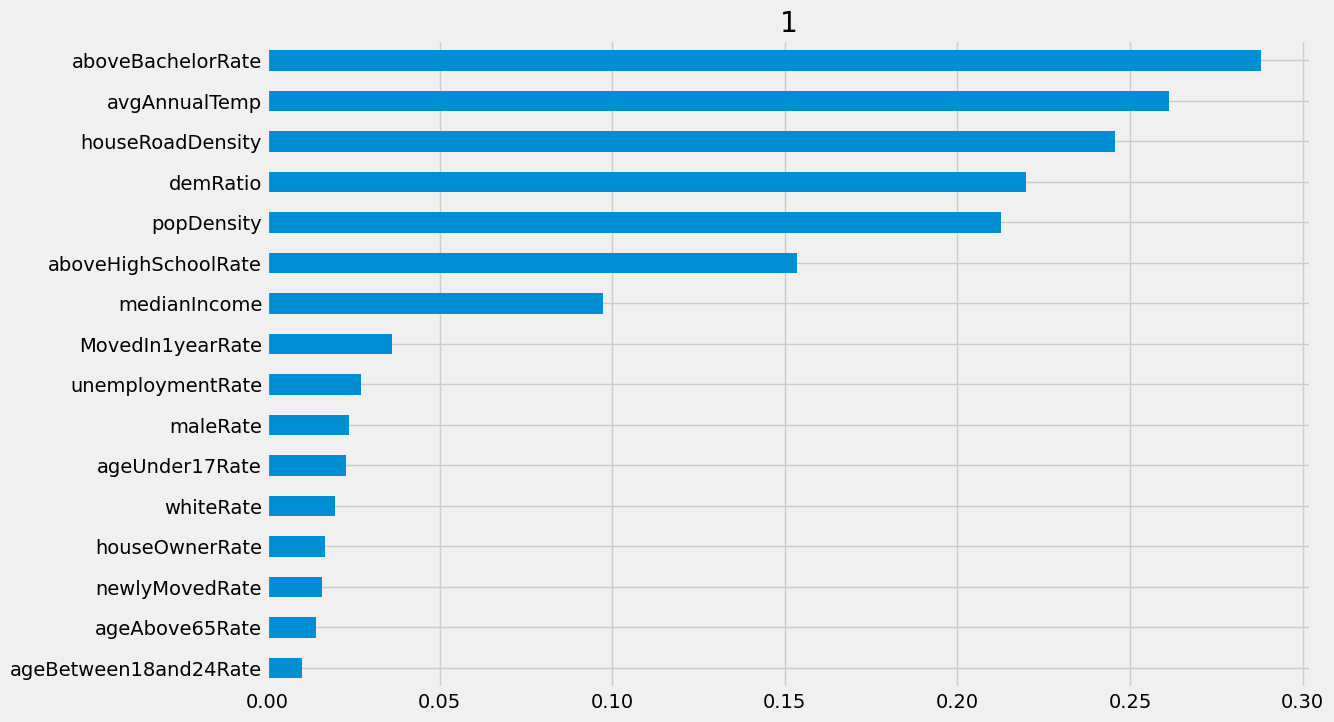

In [32]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='permutation', 
                         features=xCol)

In [33]:
tlearner = BaseTRegressor(base_algo)
tlearner.estimate_ate(X, treatment, y)

(array([0.0711794]), array([0.0685834]), array([0.07377541]))

In [34]:
tlearner_tau = tlearner.fit_predict(X, treatment, y)

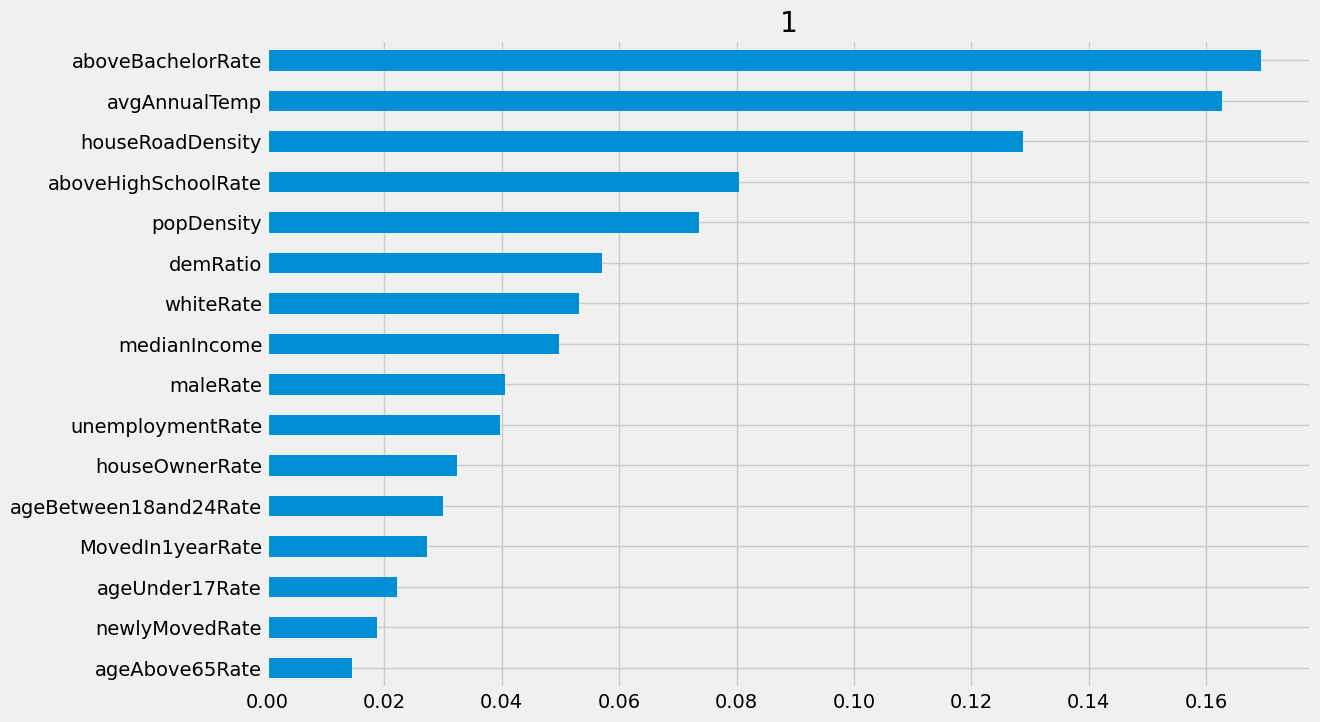

In [35]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=xCol)

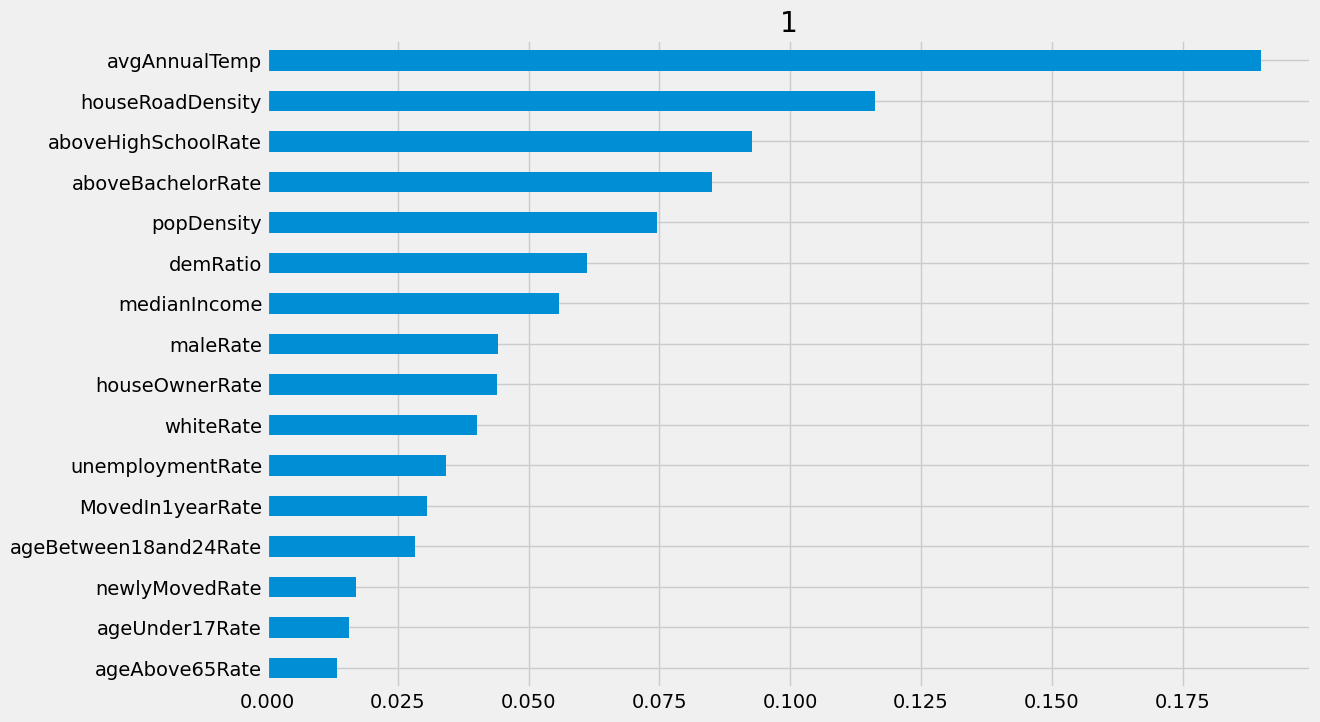

In [36]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='permutation', 
                         features=xCol)